In [1]:
import sys
sys.path.insert(0,'..')
# sys.path.append('./Unet3PlusSource/UNET/models')
from msssimLoss import MSSSIM, SSIM
# from Unet3PlusSource.UNET.models.UNet_3Plus import UNet_3Plus_DeepSup_CGM

In [2]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import numpy as np
from torch.nn import init

### Weight Initialization ###

def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

### Utility Layer ###

class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, conv_depth=2, conv_kernel_size=3, conv_stride=1, conv_padding=1):
        super(ConvBlock, self).__init__()
        self.n = conv_depth
        self.ks = conv_kernel_size
        self._stride = conv_stride
        self.padding = conv_padding
        if is_batchnorm:
            for i in range(1, self.n + 1):
                conv = nn.Sequential(nn.Conv2d(in_channels=in_size,out_channels=out_size,kernel_size=self.ks,
                                               stride=self._stride,padding=self.padding),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size
        else:
            for i in range(1, self.n + 1):
                conv = nn.Sequential(nn.Conv2d(in_channels=in_size,out_channels=out_size,kernel_size=self.ks,
                                               stride=self._stride,padding=self.padding),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

### Actual Unet3+ ###

'''
    UNet 3+ with deep supervision and class-guided module
'''
class UNet_3Plus_DeepSup_CGM(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, start_neurons:int = 32, is_batchnorm=True, conv_depth=2, conv_kernel_size=3, conv_stride=1, conv_padding=1):
        super(UNet_3Plus_DeepSup_CGM, self).__init__()
        self.feature_scale = feature_scale

        filters = [feature_scale*start_neurons*i for i in range(1,5)]
        print(filters)

        ## -------------Encoder--------------

        self.conv1 = ConvBlock(in_channels, filters[0], is_batchnorm,conv_depth, conv_kernel_size, conv_stride, conv_padding)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = ConvBlock(filters[0], filters[1], is_batchnorm,conv_depth, conv_kernel_size, conv_stride, conv_padding)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = ConvBlock(filters[1], filters[2], is_batchnorm,conv_depth, conv_kernel_size, conv_stride, conv_padding)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = ConvBlock(filters[2], filters[3], is_batchnorm,conv_depth, conv_kernel_size, conv_stride, conv_padding)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 4
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(filters[-1], self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h2->160*160, hd2->160*160, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)


        # -------------Bilinear Upsampling--------------
        #self.upscore6 = nn.Upsample(scale_factor=32,mode='bilinear')###
        self.upscore4 = nn.Upsample(scale_factor=8,mode='bilinear')
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear')
        self.upscore2 = nn.Upsample(scale_factor=2,mode='bilinear')
        self.upscore1 = nn.Upsample(scale_factor=1, mode='bilinear')

        # DeepSup
        #self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv2 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv3 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv4 = nn.Conv2d(filters[-1], n_classes, 3, padding=1)

        self.cls = nn.Sequential(
                    nn.Dropout(p=0.5),
                    nn.Conv2d(filters[-1], 2, 1),
                    nn.AdaptiveMaxPool2d(1),
                    nn.Sigmoid())

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def dotProduct(self,seg,cls):
        B, N, H, W = seg.size()
        seg = seg.view(B, N, H * W)
        final = torch.einsum("ijk,ij->ijk", [seg, cls])
        final = final.view(B, N, H, W)
        return final

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        hd4 = self.conv4(h4)  # h4->40*40*512

        # -------------Classification-------------
        cls_branch = self.cls(hd4).squeeze(3).squeeze(2)  # (B,N,1,1)->(B,N)
        cls_branch_max = cls_branch.argmax(dim=1)
        cls_branch_max = cls_branch_max[:, np.newaxis].float()

        ## -------------Decoder-------------
        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d4 = self.outconv4(hd4)
        d4 = self.upscore4(d4) # 32->256

        d3 = self.outconv3(hd3)
        d3 = self.upscore3(d3) # 64->256

        d2 = self.outconv2(hd2)
        d2 = self.upscore2(d2) # 128->256

        d1 = self.outconv1(hd1) # 256

        d1 = self.dotProduct(d1, cls_branch_max)
        d2 = self.dotProduct(d2, cls_branch_max)
        d3 = self.dotProduct(d3, cls_branch_max)
        d4 = self.dotProduct(d4, cls_branch_max)
        #d5 = self.dotProduct(d5, cls_branch_max)

        return torch.nn.Identity()(d1), torch.nn.Identity()(d2),torch.nn.Identity()(d3),torch.nn.Identity()(d4) #, torch.sigmoid(d5)

In [3]:
net = UNet_3Plus_DeepSup_CGM(in_channels=1, n_classes=3, feature_scale=3, start_neurons = 16, is_batchnorm=True, conv_depth=2, conv_kernel_size=3, conv_stride=1, conv_padding=1)

[48, 96, 144, 192]


In [4]:
import os
import random
import torch
import datetime

from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm.notebook import tqdm, trange

torch.backends.cudnn.benchmark = True

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

import glob
import albumentations as A

from torch.cuda.amp import GradScaler, autocast
plt.style.use('dark_background')

In [5]:
# from dataclasses import replace
# from locale import normalize
# import albumentations as A
# import numpy as np
# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset

# class DataGenerator(Dataset):
#     'Load, Augment and distribute batches for training & valitation.'
#     def __init__(self, files, dim=(256,256), in_channels=1, out_channels=3,
#                  aug_line:A.Compose = None, chunks:int = 8, normalie:bool = False):
#         'Initialization'
#         self.__dim = dim
#         self.__files = files
#         self.__crop_size = dim[0]
#         self.__chunks = chunks
#         self.__in_channels = in_channels
#         self.__out_channels = out_channels
#         self.__transform = aug_line
        
#         self.__get_padding()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return len(self.__files)

#     def __getitem__(self, index):
#         'Generate one sample of data'
#         self._open = self.__files[index]
#         # Generate data
#         X, y = self.__data_generation()

#         return X, y
    
#     def __get_padding(self):
#         if self.__crop_size % self.__chunks == 0:
#             self.__chunks = self.__crop_size
#         else:
#             self.__chunks = self.__crop_size + (self.__crop_size % self.__chunks)
            
#     def __data_augmentation(self, image, masks):
                        
#         tmp = self.__transform(image=np.squeeze(image, axis = 0), masks = [np.squeeze(a,axis = 0) for a in np.split(masks,indices_or_sections = self.__out_channels, axis = 0)])
        
#         return tmp['image'], tmp['masks']

#     def __data_generation(self):
#         'Generates data containing # batch_size samples'
        
#         # Initialization
#         X = np.empty((self.__in_channels, *self.__dim), dtype=np.float32)
#         y = np.empty((self.__out_channels, *self.__dim), dtype=np.float32)
                 
#         tmp = np.load(self._open)
                
#         # No Augmentation
#         if self.__transform == None:
#             self.__transform = A.Compose([A.RandomCrop(*self.__dim,always_apply=True),
#                                           A.PadIfNeeded(min_height=self.__chunks, min_width=self.__chunks,p = 1, border_mode = 0)])


#         img,masks = self.__data_augmentation(tmp[:self.__in_channels,...],tmp[self.__in_channels:,...])
        
#         # Store sample
#         if normalize:
#             X = img/np.max(img)
            
#         if not normalize:
#             X = img
        
#         if self.__in_channels == 1:
#             X = X[None,...]

#         # Store class
#         masks = np.stack(masks,axis=0)
#         if normalize:
#             y = masks/np.max(masks)
            
#         if not normalize:
#             y = masks
        
#         if self.__out_channels == 1:
#             y = y[None,...]

#         return X,y
    
# def Build_Loaders(raw_source:str, 
#                   test_source:str, 
#                   val_split:float=0.1, 
#                   dim=(256,256), 
#                   in_channels=1, 
#                   out_channels=3,
#                   raw_aug = None,
#                   test_aug = None,
#                   chunks:int = 8,
#                   BatchSize:int = 32,
#                   shuffle:bool = True,
#                   normalize:bool = False):
#     if (val_split < 1.0) and( val_split > 0.0):
#         val_source = np.random.choice(test_source, size = int(len(test_source)*val_split), replace = False)
#         test_source = [x for x in test_source if x not in val_source]
    
#     train_dataset = DataGenerator(raw_source, dim, in_channels, out_channels, raw_aug, chunks, normalize)
#     test_dataset = DataGenerator(test_source, dim, in_channels, out_channels, test_aug, chunks, normalize)
#     val_dataset = DataGenerator(val_source, dim, in_channels, out_channels, test_aug, chunks, normalize)
    
#     #return train_dataset, test_dataset
                
#     return (
#         DataLoader(train_dataset, batch_size=BatchSize, shuffle=shuffle, pin_memory=True, num_workers=6, prefetch_factor = 5),
#         DataLoader(test_dataset, batch_size=1, shuffle=False),
#         DataLoader(val_dataset, batch_size=1, shuffle=False),
#         )

In [5]:
## Hyperparams
LR = 1e-4
BatchSize = 16
StepsOnEpoch = 10000

L1 = 1e-6
L2 = 1e-5

In [6]:
train_transform = A.Compose([
    A.RandomCrop(256,256,always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.MedianBlur(p = 0.3,blur_limit=5)
])
# , A.RandomBrightnessContrast(p=0.1,contrast_limit=0.1) A.PadIfNeeded(min_height=16, min_width=16,p = 1, border_mode = 0),,
#    A.MedianBlur(p = 0,blur_limit=3)

In [7]:
test_transform = A.Compose([
    A.RandomCrop(256,256,always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

X 1.0 0.0
y1 0.96862745 0.0
y1 0.9411765 0.0
y1 0.9607843 0.0


(-0.5, 255.5, 255.5, -0.5)

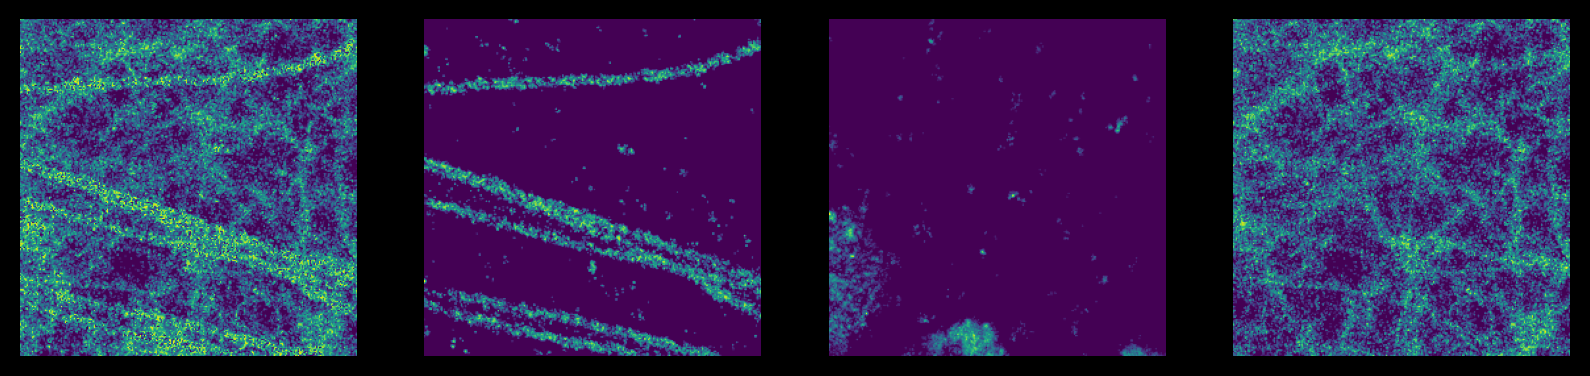

In [8]:
## DATALOADERS
from BatchDataLoader import Build_Loaders

train_gen, test_gen, val_gen = Build_Loaders(
    raw_source = glob.glob('./raw_mix/*.npy'), 
    test_source = glob.glob('./test_mix/*.npy'), 
    val_split = 0.2, 
    dim=(256,256), 
    in_channels=1, 
    out_channels=3,
    raw_aug = train_transform,
    test_aug = test_transform,
    chunks = 8,
    BatchSize=BatchSize,
    shuffle = True,
    normalize = True,
    num_workers=16)

x,y = val_gen.dataset[0]
print('X',np.max(x),np.min(x))
print('y1',np.max(y[0,...]),np.min(y[0,...]))
print('y1',np.max(y[1,...]),np.min(y[1,...]))
print('y1',np.max(y[2,...]),np.min(y[2,...]))
fig,ax = plt.subplots(1,4, figsize = (10,5), dpi = 200)
ax[0].imshow(x[0,...])
ax[0].axis('off')

ax[1].imshow(y[0])
ax[1].axis('off')

ax[2].imshow(y[1])
ax[2].axis('off')

ax[3].imshow(y[2])
ax[3].axis('off')

In [9]:
# ## DATALOADERS

# train_gen, test_gen, val_gen = Build_Loaders(
#     raw_source = glob.glob('./raw_mix/*.npy'), 
#     test_source = glob.glob('./test_mix/*.npy'), 
#     val_split = 0.2, 
#     dim=(256,256), 
#     in_channels=1, 
#     out_channels=3,
#     raw_aug = test_transform,
#     test_aug = test_transform,
#     chunks = 8,
#     BatchSize=BatchSize,
#     shuffle = True,
#     normalize = True)

# x,y = val_gen.dataset[0]
# print('X',np.max(x),np.min(x))
# print('y1',np.max(y[0,...]),np.min(y[0,...]))
# print('y1',np.max(y[1,...]),np.min(y[1,...]))
# print('y1',np.max(y[2,...]),np.min(y[2,...]))
# fig,ax = plt.subplots(1,4, figsize = (10,5), dpi = 200)
# ax[0].imshow(x[0,...])
# ax[0].axis('off')

# ax[1].imshow(y[0])
# ax[1].axis('off')

# ax[2].imshow(y[1])
# ax[2].axis('off')

# ax[3].imshow(y[2])
# ax[3].axis('off')

In [9]:
def model_step(model, loss_fn, optimizer, feature, label, L1:float = None, train_step=True):
    
    # zero gradients if training
    if train_step:
        optimizer.zero_grad()
    
    # forward
    # pass through loss
    losses = []
    predicted = model(feature)
    for pred in predicted:
        losses.append(loss_fn(input=pred, target=label))
        
    loss_value = loss_fn(input=predicted[0], target=label)

    if train_step:
        for loss in losses[1:][::-1]:
            loss.backward(retain_graph=True)
            
        loss_value.backward()    

        optimizer.step()
    
    return loss_value, predicted

In [10]:
def train(train_loader, val_loader, net, loss_fn, optimizer, dtype, writer, device, training_steps, log_interval:int = 100, prediction_type=None, save_dir:str = './model'):

    # set train flags, initialize step
    net.train() 
    loss_fn.train()
    step = 0
    print_loss = 0
    best_loss = np.infty
    best_msssim = 0
    
    l2 = MSSSIM()
    l2.to(device)
    l3 = SSIM()
    l3.to(device)

    with tqdm(total=training_steps, leave=False, desc='Current batch loss: 0') as pbar:
        while step < training_steps:
            # reset data loader to get random augmentations
            np.random.seed()
            tmp_loader = iter(train_loader)
            for feature, label in tmp_loader:
                label = label.type(dtype)
                label = label.to(device)
                feature = feature.to(device)
                loss_value, pred = model_step(model=net, loss_fn=loss_fn, optimizer=optimizer, feature=feature, label=label, L1 = L1, train_step=True)
                writer.add_scalar('loss',loss_value.cpu().detach().numpy(),step)
                writer.add_scalar('SSIM',l3(pred[0],label).cpu().detach().numpy(),step)
                writer.add_scalar('MSSSIM',l2(pred[0],label).cpu().detach().numpy(),step)
                
                # check if we log images in this iteration
                #if step % log_interval == 0:
                    # writer.add_images(
                    #     tag="input", img_tensor=feature.to("cpu"), global_step=step
                    # )
                    # writer.add_images(
                    #     tag="target", img_tensor=label.to("cpu"), global_step=step
                    # )
                    # writer.add_images(
                    #     tag="struct_1",
                    #     img_tensor=pred['pred'][0].to("cpu").detach(),
                    #     global_step=step
                    # )

                step += 1
                pbar.set_description("Current batch loss: {:.3e}".format(loss_value.cpu().detach().numpy())) 
                pbar.update(1)
                
                
                if step % 100 == 0:
                    net.eval()
                    tmp_val_loader = iter(val_loader)
                    acc_loss = []
                    acc_ssim = []
                    acc_msssim = []
                    for feature, label in tmp_val_loader:                    
                        label = label.type(dtype)
                        label = label.to(device)
                        feature = feature.to(device)
                        loss_value, val_pred = model_step(model=net, loss_fn=loss_fn, optimizer=optimizer, feature=feature, label=label, L1 = L1, train_step=False)
                        acc_loss.append(loss_value.cpu().detach().numpy())
                        acc_ssim.append(l3(val_pred[0],label).cpu().detach().numpy())
                        acc_msssim.append(l2(val_pred[0],label).cpu().detach().numpy())
                    
                    writer.add_scalar(tag="val_loss", scalar_value=np.mean(acc_loss), global_step=step)
                    writer.add_scalar('val_SSIM',scalar_value=np.mean(acc_ssim), global_step=step)
                    writer.add_scalar('val_MSSSIM',scalar_value=np.mean(acc_msssim), global_step=step)
                    
                    
                    # we always log the last validation images
                    # writer.add_images(tag="val_input", img_tensor=feature.to("cpu"), global_step=step)
                    # writer.add_images(tag="val_target", img_tensor=label.to("cpu"), global_step=step)
                    # writer.add_images(
                    #     tag="val_struct_1", img_tensor=val_pred['pred'][0].to("cpu"), global_step=step
                    # )
                                           
                    if np.mean(acc_loss) < best_loss:
                        best_loss = np.mean(acc_loss)
                        torch.save(net.state_dict(), f'{save_dir}/model_best.pt')
                        
                    if np.mean(acc_msssim) > best_msssim:
                        best_msssim = np.mean(acc_msssim)
                        torch.save(net.state_dict(), f'{save_dir}/model_best_msssim.pt')
                    
                    torch.save(net.state_dict(), f'{save_dir}/model_current.pt')
                    
                    net.train()

In [9]:
def model_step_hybrid(model, optimizer, feature, label, train_step,MSE_LOSS,MSSSIM_LOSS):
    
    # zero gradients if training
    if train_step:
        optimizer.zero_grad()

    # forward
    # pass through loss
    losses = []
    predicted = model(feature)
    for pred in predicted[1:]:
        losses.append(MSE_LOSS(pred, label)+(1-MSSSIM_LOSS(pred, label)))
        
    loss_value = MSE_LOSS(predicted[0], label) + (1-MSSSIM_LOSS(predicted[0], label))

    if train_step:
        for loss in losses[1:][::-1]:
            loss.backward(retain_graph=True)
            
        loss_value.backward()    

        optimizer.step()

    return loss_value, predicted

In [10]:
def train_hybrid(train_loader, val_loader, net, optimizer, dtype, log_interval:int = 100, prediction_type=None, save_dir:str = './model'):
    
    l1 = nn.MSELoss()
    l1.to(device)
    l2 = MSSSIM()
    l2.to(device)
    l3 = SSIM()
    l3.to(device)

    # set train flags, initialize step
    net.train() 

    l1.train()
    l2.train()
    
    step = 0
    print_loss = 0
    best_loss = np.infty

    with tqdm(total=training_steps, leave=False, desc='Current batch loss: 0') as pbar:
        while step < training_steps:
            # reset data loader to get random augmentations
            np.random.seed()
            tmp_loader = iter(train_loader)
            for feature, label in tmp_loader:
                label = label.type(dtype)
                label = label.to(device)
                feature = feature.to(device)
                loss_value, pred = model_step_hybrid(model=net, optimizer=optimizer, feature=feature, label=label, train_step=True,MSE_LOSS=l1,MSSSIM_LOSS=l2)
                writer.add_scalar('loss',loss_value.cpu().detach().numpy(),step)
                writer.add_scalar('SSIM',l3(pred[0],label).cpu().detach().numpy(),step)
                writer.add_scalar('MSSSIM',l2(pred[0],label).cpu().detach().numpy(),step)

                
                # check if we log images in this iteration
                # if step % log_image_interval == 0:
                #     writer.add_images(
                #         tag="input", img_tensor=feature.to("cpu"), global_step=step
                #     )
                #     writer.add_images(
                #         tag="target", img_tensor=label.to("cpu"), global_step=step
                #     )
                #     writer.add_images(
                #         tag="struct_1",
                #         img_tensor=pred[0].to("cpu").detach(),
                #         global_step=step
                #     )

                step += 1
                pbar.set_description("Current batch loss: {:.3e}".format(loss_value.cpu().detach().numpy())) 
                pbar.update(1)
                
                
                if step % log_interval == 0:
                    net.eval()
                    tmp_val_loader = iter(val_loader)
                    acc_loss = []
                    acc_ssim = []
                    acc_msssim = []
                    for feature, label in tmp_val_loader:                    
                        label = label.type(dtype)
                        label = label.to(device)
                        feature = feature.to(device)
                        loss_value, val_pred = model_step_hybrid(model=net, optimizer=optimizer, feature=feature, label=label, train_step=False,MSE_LOSS=l1,MSSSIM_LOSS=l2)
                        acc_loss.append(loss_value.cpu().detach().numpy())
                        acc_ssim.append(l3(val_pred[0],label).cpu().detach().numpy())
                        acc_msssim.append(l2(val_pred[0],label).cpu().detach().numpy())
                    
                    writer.add_scalar(tag="val_loss", scalar_value=np.mean(acc_loss), global_step=step)
                    writer.add_scalar('val_SSIM',scalar_value=np.mean(acc_ssim), global_step=step)
                    writer.add_scalar('val_MSSSIM',scalar_value=np.mean(acc_msssim), global_step=step)
                    
                    # # we always log the last validation images
                    # writer.add_images(tag="val_input", img_tensor=feature.to("cpu"), global_step=step)
                    # writer.add_images(tag="val_target", img_tensor=label.to("cpu"), global_step=step)
                    # writer.add_images(
                    #     tag="val_struct_1", img_tensor=val_pred[0].to("cpu"), global_step=step
                    # )
                                           
                    if np.mean(acc_loss) < best_loss:
                        best_loss = np.mean(acc_loss)
                        torch.save(net.state_dict(), f'{save_dir}/model_best.pt')
                    
                    torch.save(net.state_dict(), f'{save_dir}/model_current.pt')
                    
                    net.train()
                    
                    # print(
                    #     "\nValidate: Average loss: {:.4f}\n".format(
                    #         np.mean(acc_loss)))

In [11]:
from torch import nn
params = {
    'loss_fn':nn.MSELoss(),
    'dtype':torch.FloatTensor,
}

device = torch.device("cuda")

training_steps = StepsOnEpoch
logdir = os.path.join("torch/logs/IPHT_UNET3P_non_hyb/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

net = net.to(device)
loss_fn = params['loss_fn'].to(device)
dtype = params['dtype']

# set optimizer
learning_rate = LR
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) #, weight_decay=L2


In [9]:
#net.load_state_dict(torch.load('./model/IPHT_UNET3P/model_best.pt'))

<All keys matched successfully>

In [12]:
# run training loop
train(
    train_loader=train_gen,
    val_loader=val_gen,
    net=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    dtype=dtype,
    writer=writer,
    device=device,
    training_steps=StepsOnEpoch,
    log_interval=100,
    prediction_type=None,
    save_dir = './model/IPHT_UNET3P_non_hyb'
    )

Current batch loss: 0:   0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
# run training loop
test = train_hybrid(
    train_loader=train_gen,
    val_loader=val_gen,
    net=net,
    optimizer=optimizer,
    dtype=dtype,
    log_interval=100,
    prediction_type=None,
    save_dir = './model/IPHT_UNET3P'
    ) #,L1 = L1

Current batch loss: 0:   0%|          | 0/20000 [00:00<?, ?it/s]

In [13]:
torch.save(net.state_dict(), './model/IPHT_UNET3P/IPHT_UNET3P_200000.pt')

In [ ]:
tmp_loader = iter(train_gen)
for feature, label in tmp_loader:
    label = label.type(dtype)
    label = label.to(device)
    feature = feature.to(device)
    break

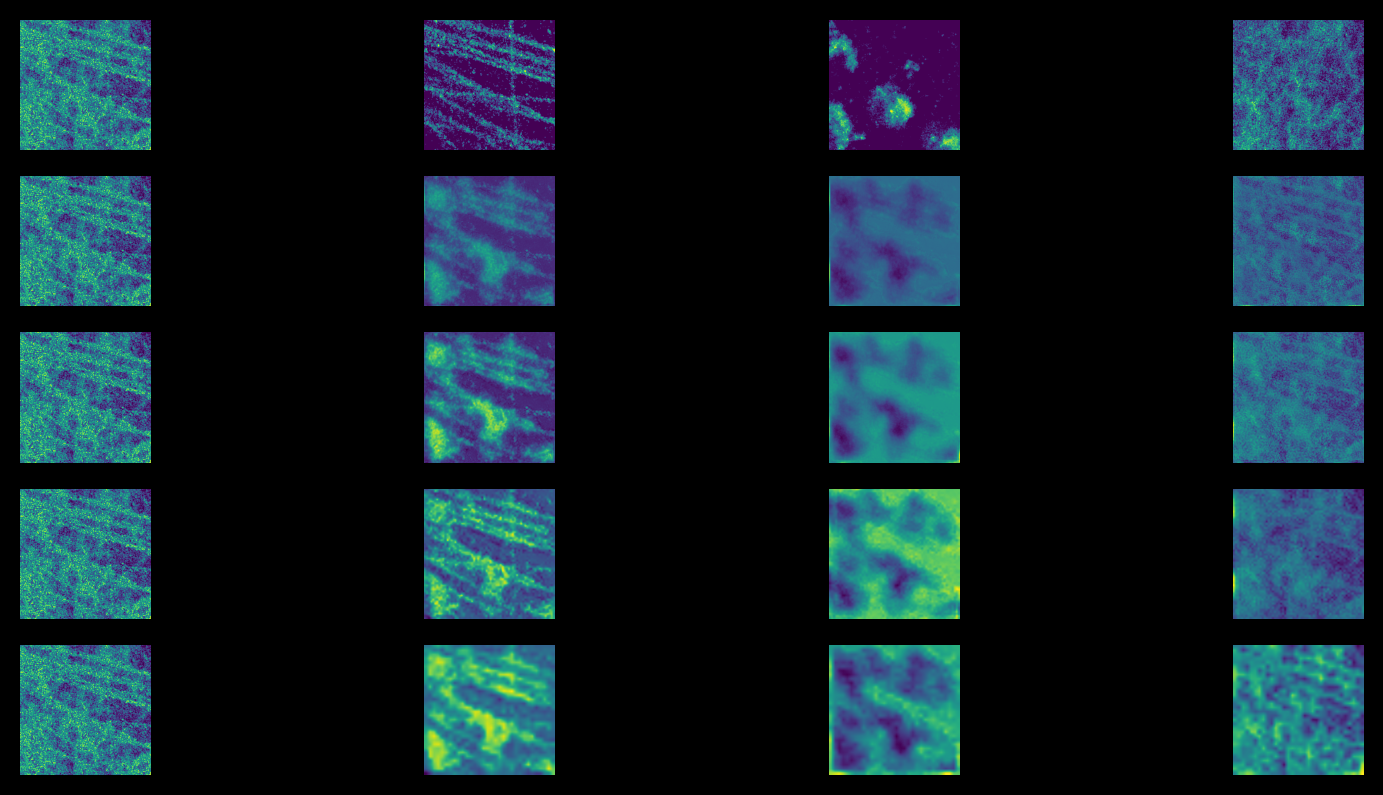

In [13]:
device = torch.device('cuda')
net.to(device)
net.eval()
for idx, (image, mask) in enumerate(test_gen):
    image = image.to(device)
    pred = net(image)
    break

plt.style.use('dark_background')
fig, ax = plt.subplots(5,4, figsize = (10,5), dpi = 200)

ax[0,0].axis('off')
ax[0,0].imshow(image.cpu().detach().numpy()[0,0,...])
ax[1,0].axis('off')
ax[1,0].imshow(image.cpu().detach().numpy()[0,0,...])
ax[2,0].axis('off')
ax[2,0].imshow(image.cpu().detach().numpy()[0,0,...])
ax[3,0].axis('off')
ax[3,0].imshow(image.cpu().detach().numpy()[0,0,...])
ax[4,0].axis('off')
ax[4,0].imshow(image.cpu().detach().numpy()[0,0,...])


for i in range(3):
    ax[0,i+1].axis('off')
    ax[0,i+1].imshow(mask.cpu().detach().numpy()[0,i,...])
for j in range(3):
    ax[1,j+1].axis('off')
    ax[1,j+1].imshow(pred[0].cpu().detach().numpy()[0,j,...])
for r in range(3):
    ax[2,r+1].axis('off')
    ax[2,r+1].imshow(pred[1].cpu().detach().numpy()[0,r,...])
for t in range(3):
    ax[3,t+1].axis('off')
    ax[3,t+1].imshow(pred[2].cpu().detach().numpy()[0,t,...])
for z in range(3):
    ax[4,z+1].axis('off')
    ax[4,z+1].imshow(pred[3].cpu().detach().numpy()[0,z,...])
    